# Python Assigment for Ch 07

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.model_selection import cross_val_score

from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot') # just optional

np.set_printoptions(precision=4) # just optional

## Import Data

In [2]:
Wages = pd.read_csv('Wage.csv')
Wages.head(3)

,Unnamed: 0,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,231655,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,86582,2004,24,1. Male,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,161300,2003,45,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177


## Polynomial Regression of Age onto Wage

Text(0, 0.5, '5-Fold CV MSE')

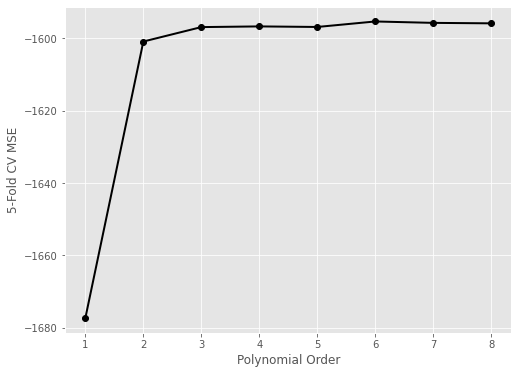

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

scores = np.array([])
orders = np.arange(1,9)
X = Wages[['age']].values
y = Wages['wage'].values

for order in orders:
    # make a polynomial (note this includes constant term)
    poly = PolynomialFeatures(order, include_bias=False)
    
    # make a linear estimator don't include intercept again...
    linear_estimator = LinearRegression(fit_intercept=True)
    
    # compute the cross validation score using 5-fold CV
    cv_score = cross_val_score(linear_estimator,
                                 poly.fit_transform(X),
                                    y,
                                    cv=KFold(5, shuffle=True, random_state=42),
                                    scoring='neg_mean_squared_error')
    
    # append the mean of the 5 scores to the scores array
    scores = np.append(scores, np.mean(cv_score))

# Plot  
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.plot(orders,scores, marker='o', lw=2,color='k')
ax.set_xlabel('Polynomial Order')
ax.set_ylabel('5-Fold CV MSE')

So the 5-Fold cross-validation suggest that a polynmial of age of order 3 or 4 is best.

In [5]:
# The Fourth order model is 
poly4 = PolynomialFeatures(4).fit_transform(X)
linear_mod4 = LinearRegression(fit_intercept=False)
linear_mod4.fit(X=poly4, y=Wages.wage)
print('coeffecients =', linear_mod4.coef_)
# Explained variance score R^2=1 is perfect prediction
print('Variance score: %.2f' % linear_mod4.score(X=poly4, y=Wages.wage))

coeffecients = [-1.8415e+02  2.1246e+01 -5.6386e-01  6.8107e-03 -3.2038e-05]
Variance score: 0.09


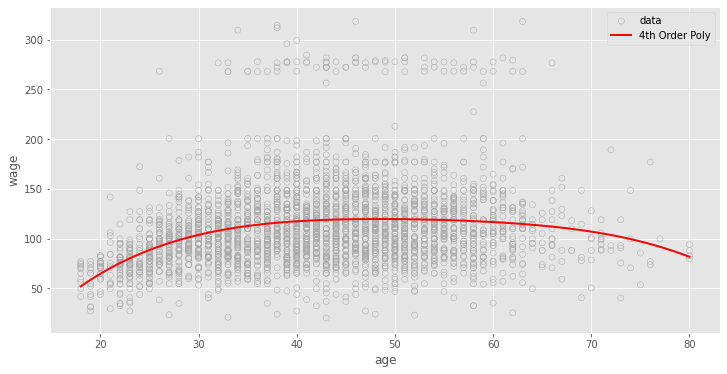

In [6]:
# Lastly, lets plot the data and the fit
fig, ax = plt.subplots(1,1,figsize=(12,6))
ax.scatter(Wages.age, Wages.wage, facecolors='none', edgecolors='darkgray', label='data')

# make a set of prediction wages from an age_grid
age_grid = np.linspace(Wages.age.min(), Wages.age.max(),1000).reshape(-1,1)
# Transform ages into a polynomial matrix
age_poly = PolynomialFeatures(4).fit_transform(age_grid)
# make predictions
predictions = linear_mod4.predict(age_poly)

# plot predictions
ax.plot(age_grid, predictions, lw=2, color='r', label='4th Order Poly')
ax.set_xlabel('age')
ax.set_ylabel('wage')
ax.legend(loc='best')

## Step Function of Age onto Wage

Text(0, 0.5, '5-Fold CV MSE')

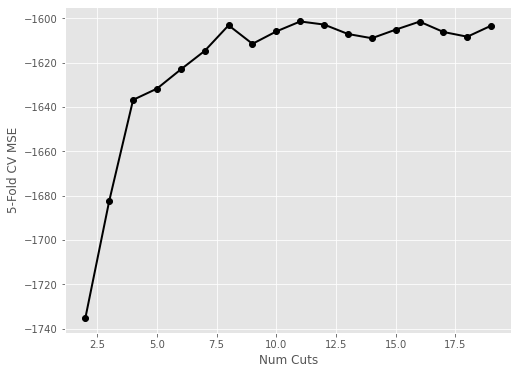

In [11]:
bns = np.arange(2,20)
scores = np.array([])

for cuts in bns:
    # return a dataframe of ages cut into bins
    df = pd.cut(Wages.age, cuts, retbins=False, include_lowest=True)
    
    # create a dummies dataframe using the cut value pairs as labels
    dummies = pd.get_dummies(df, prefix='age')
    
    # build a linear model -- remember to drop first bin since bins are categoricals
    linear_estimator = LinearRegression(fit_intercept=True)
    
    # compute the cross validation score using 5-fold CV
    cv_score = cross_val_score(linear_estimator,
                                    dummies.iloc[:,1:],
                                    y,
                                    cv=KFold(5, shuffle=True, random_state=42),
                                    scoring='neg_mean_squared_error')
    
    # append the mean of the 5 scores to the scores array
    scores = np.append(scores, np.mean(cv_score))
    
# Plot  
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.plot(bns,scores, marker='o', lw=2,color='k')
ax.set_xlabel('Num Cuts')
ax.set_ylabel('5-Fold CV MSE')

So 8 cuts seems to be optimal. Lets make a plot of the data with an 8 cut step function.

In [12]:
# return a cut dataframe and make dummy variable of the cut regions
cut_df, bins = pd.cut(Wages.age, bins=8, retbins=True, right=False)
cut_df.head()
dummy_df = pd.get_dummies(cut_df)
dummy_df.head()

,"[18.0, 25.75)","[25.75, 33.5)","[33.5, 41.25)","[41.25, 49.0)","[49.0, 56.75)","[56.75, 64.5)","[64.5, 72.25)","[72.25, 80.062)"
0,1,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0
3,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,0


In [13]:
# perform a linear regression- be sure to drop the first categorical column
lm = LinearRegression(fit_intercept=True)
steps = dummy_df.drop(dummy_df.columns[0], axis=1)
model = lm.fit(X=steps.values, y=Wages.wage)
print(lm.intercept_, lm.coef_)

76.28175472097084 [25.8333 40.2257 43.4577 40.6602 44.1024 28.9482 15.2242]


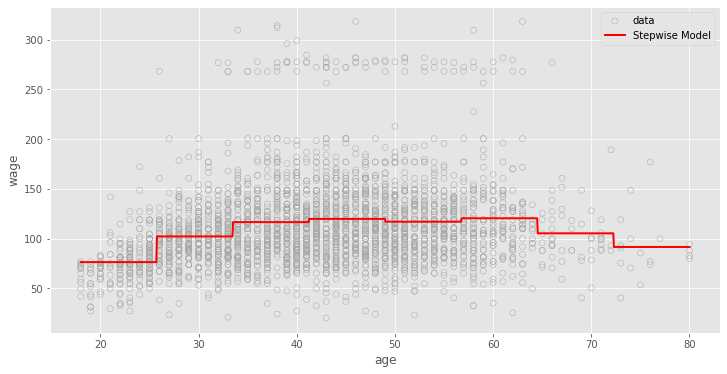

In [14]:
# Lastly, plot the data and the fit
fig, ax = plt.subplots(1,1,figsize=(12,6))
ax.scatter(Wages.age, Wages.wage, facecolors='none', edgecolors='darkgray', label='data')

# make a set of prediction wages from an age_grid
age_grid = np.linspace(Wages.age.min(), Wages.age.max(),1000).reshape(-1,1)
# place each age into a bin
age_bins = np.digitize(age_grid.ravel(), bins)
age_dummies = pd.get_dummies(age_bins).drop([1], axis=1)
# make predictions
predictions = lm.predict(age_dummies.values)

# plot predictions
ax.plot(age_grid, predictions, lw=2, color='r', label='Stepwise Model')
ax.set_xlabel('age')
ax.set_ylabel('wage')
ax.legend(loc='best')